# Modélisation de la Mortalité Individuelle et Équité Algorithmique

Notebook disponible sur https://curiousml.github.io/, préparé pour la formation Data Science pour l'Actuariat, Juin 2025

Ce notebook est conçu comme un cours pratique pour aborder la prédiction de la mortalité en milieu hospitalier tout en intégrant une dimension cruciale : l'équité algorithmique.

### Objectifs

- **Modélisation du Risque :** Comprendre et implémenter des modèles de Machine Learning (Régression Logistique, LightGBM) pour prédire un risque de mortalité, en construisant un pipeline complet : préparation des données, apprentissage et validation.
- **Diagnostic des Biais :** Comprendre comment les biais peuvent s'introduire dans les modèles hospitaliers, en s'inspirant du cas d'étude de *Science (2019)* où un algorithme sous-estimait la gravité des patients noirs.
- **Identification de l'Inéquité :** Choisir et interpréter des métriques d'équité (parité prédictive, calibration par groupe) pour quantifier ces biais sur un jeu de données réel.
- **Arbitrage Performance-Équité :** Comprendre que l'optimisation d'un modèle n'est pas seulement une question de performance globale (ex: AUROC), mais aussi un arbitrage avec l'équité, et comment des choix (comme le seuil de décision) influencent cet équilibre.

## 0. Préambule : Configuration et Fonctions Utilitaires

Avant de commencer l'analyse, nous allons configurer notre environnement. Cette section contient :
1. L'importation de toutes les bibliothèques nécessaires.
2. La définition des fonctions utilitaires que nous utiliserons tout au long du notebook pour le chargement, le prétraitement et la visualisation des données.

### 0.1. Importation des bibliothèques

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import statsmodels.api as sm
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc
)

# Configuration esthétique pour les graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### 0.2. Définition des Fonctions

Nous regroupons ici toutes les fonctions pour garder le corps du notebook propre et focalisé sur l'analyse.

#### 0.2.1. Chargement et Nettoyage Initial

In [2]:
def load_gossis_data(labeled, unlabeled, target_feature="hospital_death", sensitive_group="African American", blackbox_feature="apache_4a_hospital_death_prob"):
    """
    Charge, nettoie et transforme les données GOSSIS pour la modélisation.
    - Filtre les colonnes avec plus de 10% de valeurs manquantes.
    - Supprime les lignes avec des valeurs manquantes restantes.
    - Encode la variable sensible 'ethnicity' (1 pour le groupe sensible, -1 pour les autres).
    - Extrait les scores d'un modèle "boîte noire" existant.
    """
    print("="*60)
    print("ÉTAPE 1 : CHARGEMENT ET NETTOYAGE INITIAL DES DONNÉES")
    print("="*60)
    
    id_cols = {col for col in labeled.columns if "id" in col}
    feature_cols = [col for col in labeled.columns if col not in id_cols]
    
    labeled_data = labeled[feature_cols].copy()
    unlabeled_data = unlabeled[feature_cols].copy()
    print(f"\nDimensions initiales : Labeled={labeled_data.shape}, Unlabeled={unlabeled_data.shape}")

    # Filtrer les colonnes avec trop de NaN
    nan_threshold = len(labeled_data) / 10
    features_to_keep = labeled_data.columns[labeled_data.isna().sum() < nan_threshold].tolist()
    print(f"\nFiltrage des colonnes (>10% de NaN). {len(features_to_keep)} colonnes restantes.")
    
    # Supprimer les lignes avec des NaN restants
    labeled_data = labeled_data[features_to_keep].dropna()
    unlabeled_data = unlabeled_data[list(set(features_to_keep) - {target_feature})].dropna()
    print(f"-> Dimensions après nettoyage des NaN : Labeled={labeled_data.shape}, Unlabeled={unlabeled_data.shape}")

    # Encoder la variable sensible
    print(f"\nEncodage du groupe sensible '{sensitive_group}' dans la colonne 'ethnicity'...")
    labeled_data['ethnicity'] = np.where(labeled_data['ethnicity'] == sensitive_group, 1, -1)
    unlabeled_data['ethnicity'] = np.where(unlabeled_data['ethnicity'] == sensitive_group, 1, -1)
    print(f"-> Valeurs possibles : {labeled_data['ethnicity'].unique()}")

    # Extraction des scores de la boîte noire
    if blackbox_feature is None:
        print("\nAucun score 'boîte noire' spécifié.")
        labeled_scores = pd.Series(name="blackbox_score")
        unlabeled_scores = pd.Series(name="blackbox_score")
    else:
        print(f"\nExtraction des scores prédéfinis de '{blackbox_feature}'...")
        labeled_scores = labeled_data[blackbox_feature].copy()
        unlabeled_scores = unlabeled_data[blackbox_feature].copy()

    return (
        labeled_data, labeled_scores, labeled_data.ethnicity,
        unlabeled_data, unlabeled_scores, unlabeled_data.ethnicity
    )

#### 0.2.2. Prétraitement des Variables (Features)

In [3]:
def preprocess_features(labeled_data, unlabeled_data, target_feature, sensitive_feature, categorical_features, ordinal_features, no_change_features, do_scale=True):
    """
    Prépare les données pour l'apprentissage en encodant les variables.
    - Sélectionne les colonnes pertinentes.
    - Applique le Label Encoding aux variables ordinales.
    - Applique le One-Hot Encoding aux variables catégorielles.
    """
    print("\n" + "="*60)
    print("ÉTAPE 2 : PRÉTRAITEMENT DES VARIABLES (ENCODAGE)")
    print("="*60)

    all_features = categorical_features + ordinal_features + no_change_features + [sensitive_feature]
    labeled_data = labeled_data[all_features + [target_feature]]
    unlabeled_data = unlabeled_data[all_features]
    
    data_orig_names = labeled_data.copy()
    print("\nCaractéristiques originales (échantillon) :")
    print(data_orig_names.head(3))
    print(f"Dimensions originales : {data_orig_names.shape}")

    # Combinaison pour un encodage cohérent
    print("\nCombinaison des données pour un encodage cohérent...")
    combined_data = pd.concat([labeled_data.drop(columns=[target_feature]), unlabeled_data], ignore_index=True)
    
    # Encodage Ordinal
    print(f"\nApplication du Label Encoding sur {len(ordinal_features)} variable(s) ordinale(s)...")
    for var in ordinal_features:
        combined_data[var] = LabelEncoder().fit_transform(combined_data[var])

    # One-Hot Encoding
    print(f"\nApplication du One-Hot Encoding sur {len(categorical_features)} variable(s) catégorielle(s)...")
    shape_before = combined_data.shape
    combined_data = pd.get_dummies(combined_data, columns=categorical_features, dummy_na=False)
    print(f"-> Changement de dimensions de {shape_before} à {combined_data.shape}")

    # Séparation en jeux traités
    labeled_processed = combined_data.iloc[:len(labeled_data)].copy()
    unlabeled_processed = combined_data.iloc[len(labeled_data):].copy()
    labeled_processed[target_feature] = labeled_data[target_feature].values
    
    print("\nDonnées après encodage (échantillon) :")
    print(labeled_processed.head(3))
    
    if do_scale:
        print("\nNOTE : La normalisation (scaling) sera gérée après la séparation des données pour éviter les fuites.")
    
    return labeled_processed, unlabeled_processed, data_orig_names

#### 0.2.3. Séparation et Préparation pour l'Entraînement

In [4]:
def generate_X_y(data, target_feature):
    """Sépare les données en variables (X) et cible (y)."""
    print(f"\nSéparation des variables (X) de la cible '{target_feature}' (y)...")
    y = data[target_feature]
    X = data.drop(columns=target_feature)
    return X, y.values.ravel() # .ravel() assure que y est un tableau 1D


def train_test_split_with_sensitive_feature(X, y, sensitive_feature, test_size=0.3, split_seed=42):
    """Sépare les données en jeux d'entraînement et de test, et isole la variable sensible."""
    print("\n" + "="*60)
    print("ÉTAPE 3 : SÉPARATION DES DONNÉES (TRAIN/TEST)")
    print("="*60)

    # Séparation en train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=split_seed, stratify=y)

    print("\nLes données ont été divisées en jeux d'entraînement et de test.")
    
    # Affichage des statistiques
    for name, (X_set, y_set) in {'Entraînement': (X_train, y_train), 'Test': (X_test, y_test)}.items():
        print(f"\n--- Jeu d'{name} ---")
        print(f"Variables (X) : {X_set.shape}")
        unique, counts = np.unique(y_set, return_counts=True)
        print(f"Distribution de la mortalité (y) : {dict(zip(unique, counts))}")

    # Isoler et retirer la variable sensible
    s_train = X_train[sensitive_feature].copy()
    s_test = X_test[sensitive_feature].copy()

    X_train_final = X_train.drop(columns=[sensitive_feature])
    X_test_final = X_test.drop(columns=[sensitive_feature])

    print("\n" + "-"*60)
    print(f"La variable sensible '{sensitive_feature}' a été séparée des jeux de variables X.")
    
    return X_train_final, X_test_final, s_train, s_test, y_train, y_test

#### 0.2.4. Fonctions d'Analyse et de Visualisation

In [5]:
def analyze_and_plot_predictive_parity(y_true, y_pred, sensitive_features, group_names=None, class_names=None, colors=None, title="Taux de Vrais Positifs par Classe et par Groupe"):
    """
    Analyse et visualise la performance d'un modèle (rappel par classe) 
    à travers différents groupes sensibles.
    """
    results_df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'group': sensitive_features
    })
    
    unique_groups = sorted(results_df['group'].unique())
    unique_classes = sorted(results_df['y_true'].unique())
    
    recall_scores = {}
    for group in unique_groups:
        for cls in unique_classes:
            group_data = results_df[results_df['group'] == group]
            true_positives = np.sum((group_data['y_pred'] == cls) & (group_data['y_true'] == cls))
            actual_positives = np.sum(group_data['y_true'] == cls)
            recall = true_positives / actual_positives if actual_positives > 0 else 0
            
            class_label = class_names.get(cls, f"Classe {cls}") if class_names else f"Classe {cls}"
            group_label = group_names.get(group, f"Groupe {group}") if group_names else f"Groupe {group}"
            
            if class_label not in recall_scores:
                recall_scores[class_label] = {}
            recall_scores[class_label][group] = recall

    plot_df = pd.DataFrame(recall_scores).T

    if colors is None:
        default_colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(unique_groups)))
        colors = dict(zip(unique_groups, default_colors))
    
    ax = plot_df.plot(kind='bar', color=[colors.get(g) for g in plot_df.columns], 
                      figsize=(12, 7), width=0.8, edgecolor='black', legend=False)

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel("Taux de Vrais Positifs (Rappel)", fontsize=12)
    plt.xlabel("Classe de Résultat", fontsize=12)
    plt.xticks(rotation=0, ha='center', fontsize=12)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    if group_names is None:
        group_names = {g: f"Groupe {g}" for g in unique_groups}

    legend_patches = [mpatches.Patch(color=colors[group], label=group_names[group]) for group in unique_groups]
    plt.legend(handles=legend_patches, title='Groupe Sensible', fontsize=10)

    plt.tight_layout()
    plt.show()
    

def plot_calibration_by_group(y_true, y_probas, sensitive_features, n_bins=10, group_names=None, colors=None, title="Courbe de Calibration par Groupe", auto_zoom=True):
    """
    Trace la courbe de calibration d'un modèle pour différents groupes sensibles.
    """
    df = pd.DataFrame({
        'y_true': y_true,
        'y_probas': y_probas,
        'group': sensitive_features
    })

    try:
        bins = np.quantile(df['y_probas'], q=np.linspace(0, 1, n_bins + 1))
        df['prob_bin'] = pd.cut(df['y_probas'], bins=bins, labels=False, include_lowest=True, duplicates='drop')
    except ValueError:
        print(f"Avertissement : Impossible de créer {n_bins} bins uniques. Le nombre de bins peut être réduit.")
        df['prob_bin'] = pd.qcut(df['y_probas'], q=n_bins, labels=False, duplicates='drop')

    calibration_data = df.groupby(['prob_bin', 'group']).agg(
        mean_predicted_prob=('y_probas', 'mean'),
        fraction_of_positives=('y_true', 'mean')
    ).reset_index()

    plt.figure(figsize=(10, 8))
    unique_groups = sorted(df['group'].unique())
    
    if group_names is None: group_names = {g: f"Groupe {g}" for g in unique_groups}
    if colors is None:
        default_colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(unique_groups)))
        colors = {g: default_colors[i] for i, g in enumerate(unique_groups)}
        
    markers = ['o', 's', '^', 'D', 'v', '<', '>']

    for i, group in enumerate(unique_groups):
        subset = calibration_data[calibration_data['group'] == group]
        plt.plot(subset['mean_predicted_prob'], subset['fraction_of_positives'], 
                 linestyle='-', marker=markers[i % len(markers)], 
                 color=colors.get(group, 'black'), 
                 label=group_names.get(group, f"Groupe {group}"))

    plt.plot([0, 1], [0, 1], 'k--', label='Calibration Parfaite')

    if auto_zoom:
        min_val = min(calibration_data['mean_predicted_prob'].min(), calibration_data['fraction_of_positives'].min()) - 0.05
        max_val = max(calibration_data['mean_predicted_prob'].max(), calibration_data['fraction_of_positives'].max()) + 0.05
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
    else:
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel("Probabilité Prédite Moyenne (Confiance du Modèle)", fontsize=12)
    plt.ylabel("Fréquence Observée des Décès (Réalité)", fontsize=12)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(title="Groupe")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def analyze_and_plot_coefficients(X, y, p_value_threshold=0.05, show_only_significant=True, figsize=(12, 10), title="Importance des Facteurs de Risque (Régression Logistique)"):
    """
    Ajuste un modèle logistique, retourne les résultats et trace un barplot 
    des coefficients pour visualiser leur impact et leur significativité.
    """
    print("Ajustement du modèle de régression logistique avec statsmodels...")
    X_const = sm.add_constant(X.astype(float), has_constant='add')
    logit_model = sm.Logit(y, X_const)
    result = logit_model.fit(disp=0)

    summary_df = pd.DataFrame({
        'Coefficient': result.params,
        'p-value': result.pvalues
    }).drop('const', errors='ignore')
    
    summary_df['is_significant'] = summary_df['p-value'] < p_value_threshold
    significant_vars = summary_df[summary_df['is_significant']].index.tolist()

    plot_df = summary_df.copy()
    plot_df['abs_coefficient'] = plot_df['Coefficient'].abs()
    
    if show_only_significant:
        plot_df = plot_df[plot_df['is_significant']]
        title = f"Facteurs de Risque Significatifs (p < {p_value_threshold})"
        
    plot_df = plot_df.sort_values('abs_coefficient', ascending=True)

    colors = ['royalblue' if x > 0 else 'firebrick' for x in plot_df['Coefficient']]
    plot_df['variable_label'] = plot_df.index + plot_df['is_significant'].apply(lambda is_sig: ' **' if is_sig else '')
    
    if plot_df.empty:
        print("Aucune variable significative à afficher avec le seuil choisi.")
        return summary_df, significant_vars

    plt.figure(figsize=figsize)
    bars = plt.barh(plot_df['variable_label'], plot_df['abs_coefficient'], color=colors)
    
    plt.bar_label(bars, labels=[f"{coeff:.2f}" for coeff in plot_df['Coefficient']], padding=3)
    
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel("Impact sur le Risque (Valeur Absolue du Coefficient)", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    legend_patches = [
        mpatches.Patch(color='royalblue', label='Effet Positif (Augmente le Risque)'),
        mpatches.Patch(color='firebrick', label='Effet Négatif (Diminue le Risque)'),
    ]
    plt.legend(handles=legend_patches, loc='lower right', title=f'** p < {p_value_threshold}')
    
    plt.tight_layout()
    plt.show()
    
    return summary_df, significant_vars

## 1. Chargement et Exploration des Données (EDA)

La première étape de tout projet de modélisation est de bien comprendre les données. Nous allons :
1. Charger les jeux de données étiquetés et non étiquetés.
2. Afficher un aperçu pour comprendre leur structure.
3. Analyser les distributions des variables et leur corrélation avec la cible.

### 1.1. Chargement des Fichiers CSV

In [6]:
import requests, zipfile, io

# URL brute vers le fichier zip (raw.githubusercontent.com)
url = "https://github.com/curiousML/curiousml.github.io/raw/master/teaching/DSA/labeled.zip"

# Télécharger et décompresser directement en mémoire
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("labeled_dataset")  # dossier de destination

print("Fichiers extraits dans le dossier 'labeled_dataset'")


Fichiers extraits dans le dossier 'labeled_dataset'


In [7]:
import requests, zipfile, io

# URL brute vers le fichier zip (raw.githubusercontent.com)
url = "https://github.com/curiousML/curiousml.github.io/raw/master/teaching/DSA/unlabeled.zip"

# Télécharger et décompresser directement en mémoire
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("unlabeled_dataset")  # dossier de destination

print("Fichiers extraits dans le dossier 'unlabeled_dataset'")


Fichiers extraits dans le dossier 'unlabeled_dataset'


In [8]:
chemin_df_labeled = "labeled_dataset/labeled.csv"
chemin_df_unlabeled = "unlabeled_dataset/unlabeled.csv"

df_labeled = pd.read_csv(chemin_df_labeled)
df_unlabeled = pd.read_csv(chemin_df_unlabeled)

### 1.2. Premier Aperçu des Données
Vérifions les premières lignes, les types de données et les statistiques descriptives de base pour le jeu de données étiqueté.

In [9]:
print("Aperçu des données étiquetées :")
display(df_labeled.head())

print("\nInformations sur les colonnes et les valeurs manquantes :")
df_labeled.info()

print("\nStatistiques descriptives des variables numériques :")
display(df_labeled.describe())

Aperçu des données étiquetées :


encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   
2        119783       50777          118               0  25.0  31.95   
3         79267       46918          118               0  81.0  22.64   
4         92056       34377           33               0  19.0    NaN   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   
2                 0  Caucasian      F   172.7  ...  0.0       0.0   
3                 1  Caucasian      F   165.1  ...  0.0       0.0   
4                 0  Caucasian      M   188.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   
2                0.0             0.0               0.0       0.0       0.0   
3                0.0             0.0               0.0       0.0       0.0   
4                0.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  
2                          0.0             Metabolic            Metabolic  
3                          0.0        Cardiovascular       Cardiovascular  
4                          0.0                Trauma               Trauma  

[5 rows x 186 columns]


Informations sur les colonnes et les valeurs manquantes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB

Statistiques descriptives des variables numériques :


encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.000000     23.641975          0.000000    162.500000   
50%       65.000000     27.654655          0.000000    170.100000   
75%       75.000000     32.930206          0.000000    177.800000   
max       89.000000     67.814990          1.000000    195.590000   

             icu_id  pre_icu_los_days  ...  apache_4a_hospital_death_prob  \
count  91713.000000      91713.000000  ...                   83766.000000   
mean     508.357692          0.835766  ...                       0.086787   
std      228.989661          2.487756  ...                       0.247569   
min       82.000000        -24.947222  ...                      -1.000000   
25%      369.000000          0.035417  ...                       0.020000   
50%      504.000000          0.138889  ...                       0.050000   
75%      679.000000          0.409028  ...                       0.130000   
max      927.000000        159.090972  ...                       0.990000   

       apache_4a_icu_death_prob          aids     cirrhosis  \
count              83766.000000  90998.000000  90998.000000   
mean                   0.043955      0.000857      0.015693   
std                    0.217341      0.029265      0.124284   
min                   -1.000000      0.000000      0.000000   
25%                    0.010000      0.000000      0.000000   
50%                    0.020000      0.000000      0.000000   
75%                    0.060000      0.000000      0.000000   
max                    0.970000      1.000000      1.000000   

       diabetes_mellitus  hepatic_failure  immunosuppression      leukemia  \
count       90998.000000     90998.000000       90998.000000  90998.000000   
mean            0.225192         0.012989           0.026165      0.007066   
std             0.417711         0.113229           0.159628      0.083763   
min             0.000000         0.000000           0.000000      0.000000   
25%             0.000000         0.000000           0.000000      0.000000   
50%             0.000000         0.000000           0.000000      0.000000   
75%             0.000000         0.000000           0.000000      0.000000   
max             1.000000         1.000000           1.000000      1.000000   

           lymphoma  solid_tumor_with_metastasis  
count  90998.000000                 90998.000000  
mean       0.004132                     0.020638  
std        0.064148                     0.142169  
min        0.000000                     0.000000  
25%        0.000000                     0.000000  
50%        0.000000                     0.000000  
75%        0.000000                     0.000000  
max        1.000000                     1.000000  

[8 rows x 178 columns]

### 1.3. Nettoyage initial et sélection des variables
Avant l'exploration, nous effectuons un premier nettoyage en utilisant notre fonction `load_gossis_data` pour retirer les colonnes et lignes avec trop de valeurs manquantes.

In [10]:
labeled_data, blackbox_scores_labeled, s_labeled, unlabeled_data, blackbox_scores_unlabeled, s_unlabeled = load_gossis_data(
    labeled=df_labeled,
    unlabeled=df_unlabeled,
    target_feature="hospital_death",
    sensitive_group="African American",
    blackbox_feature="apache_4a_hospital_death_prob"
)

ÉTAPE 1 : CHARGEMENT ET NETTOYAGE INITIAL DES DONNÉES

Dimensions initiales : Labeled=(91713, 180), Unlabeled=(39308, 180)

Filtrage des colonnes (>10% de NaN). 77 colonnes restantes.
-> Dimensions après nettoyage des NaN : Labeled=(59617, 77), Unlabeled=(23782, 76)

Encodage du groupe sensible 'African American' dans la colonne 'ethnicity'...
-> Valeurs possibles : [-1  1]

Extraction des scores prédéfinis de 'apache_4a_hospital_death_prob'...


### 1.4. Sélection des variables pour l'analyse
Nous choisissons un sous-ensemble de variables pour notre modélisation afin de garder le cours focalisé. Ces variables incluent des données démographiques, des signes vitaux et des comorbidités.

In [11]:
# Listes de variables sélectionnées
categorical_features = ["apache_2_bodysystem", "icu_admit_source"]
ordinal_features = ["gender"]
numerical_features = [
    "age", "bmi", "immunosuppression",
    "d1_diasbp_noninvasive_max", "d1_sysbp_noninvasive_max",
    "d1_heartrate_min", "resprate_apache", "d1_sysbp_min",
    "d1_spo2_min", "d1_glucose_max", "pre_icu_los_days", "map_apache"
]
sensitive_feature="ethnicity"
target_feature = "hospital_death"

all_selected_features = categorical_features + ordinal_features + numerical_features + [sensitive_feature, target_feature]
df_analysis = labeled_data[all_selected_features].copy()

### 1.5. Analyse du Déséquilibre des Classes
L'un des défis majeurs dans la modélisation de la mortalité est le déséquilibre des classes : il y a beaucoup plus de survivants que de décès. Cela peut biaiser le modèle.

C:\Users\francois.hu\AppData\Local\Temp\ipykernel_29968\1650375066.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_feature, data=df_analysis, palette='viridis')


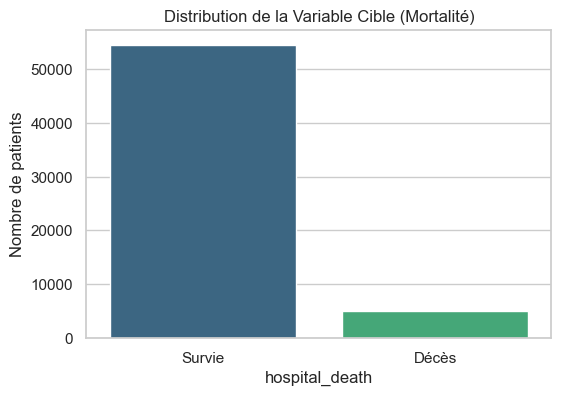

hospital_death
0    0.914521
1    0.085479
Name: proportion, dtype: float64


In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_feature, data=df_analysis, palette='viridis')
plt.title('Distribution de la Variable Cible (Mortalité)')
plt.xticks([0, 1], ['Survie', 'Décès'])
plt.ylabel('Nombre de patients')
plt.show()

print(df_analysis[target_feature].value_counts(normalize=True))

### 1.6. Visualisation de la Relation entre Variables et Mortalité

C:\Users\francois.hu\AppData\Local\Temp\ipykernel_29968\1141348774.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'{feature}_cat', y=target_feature, data=df_analysis, ax=axes[idx], palette='viridis')
C:\Users\francois.hu\AppData\Local\Temp\ipykernel_29968\1141348774.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(bin_labels, rotation=45, ha='right')
C:\Users\francois.hu\AppData\Local\Temp\ipykernel_29968\1141348774.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f'{feature}_cat', y=target_feature, data=df_analysis, ax=axes[idx], palette='viridis')
C:\Users\fran

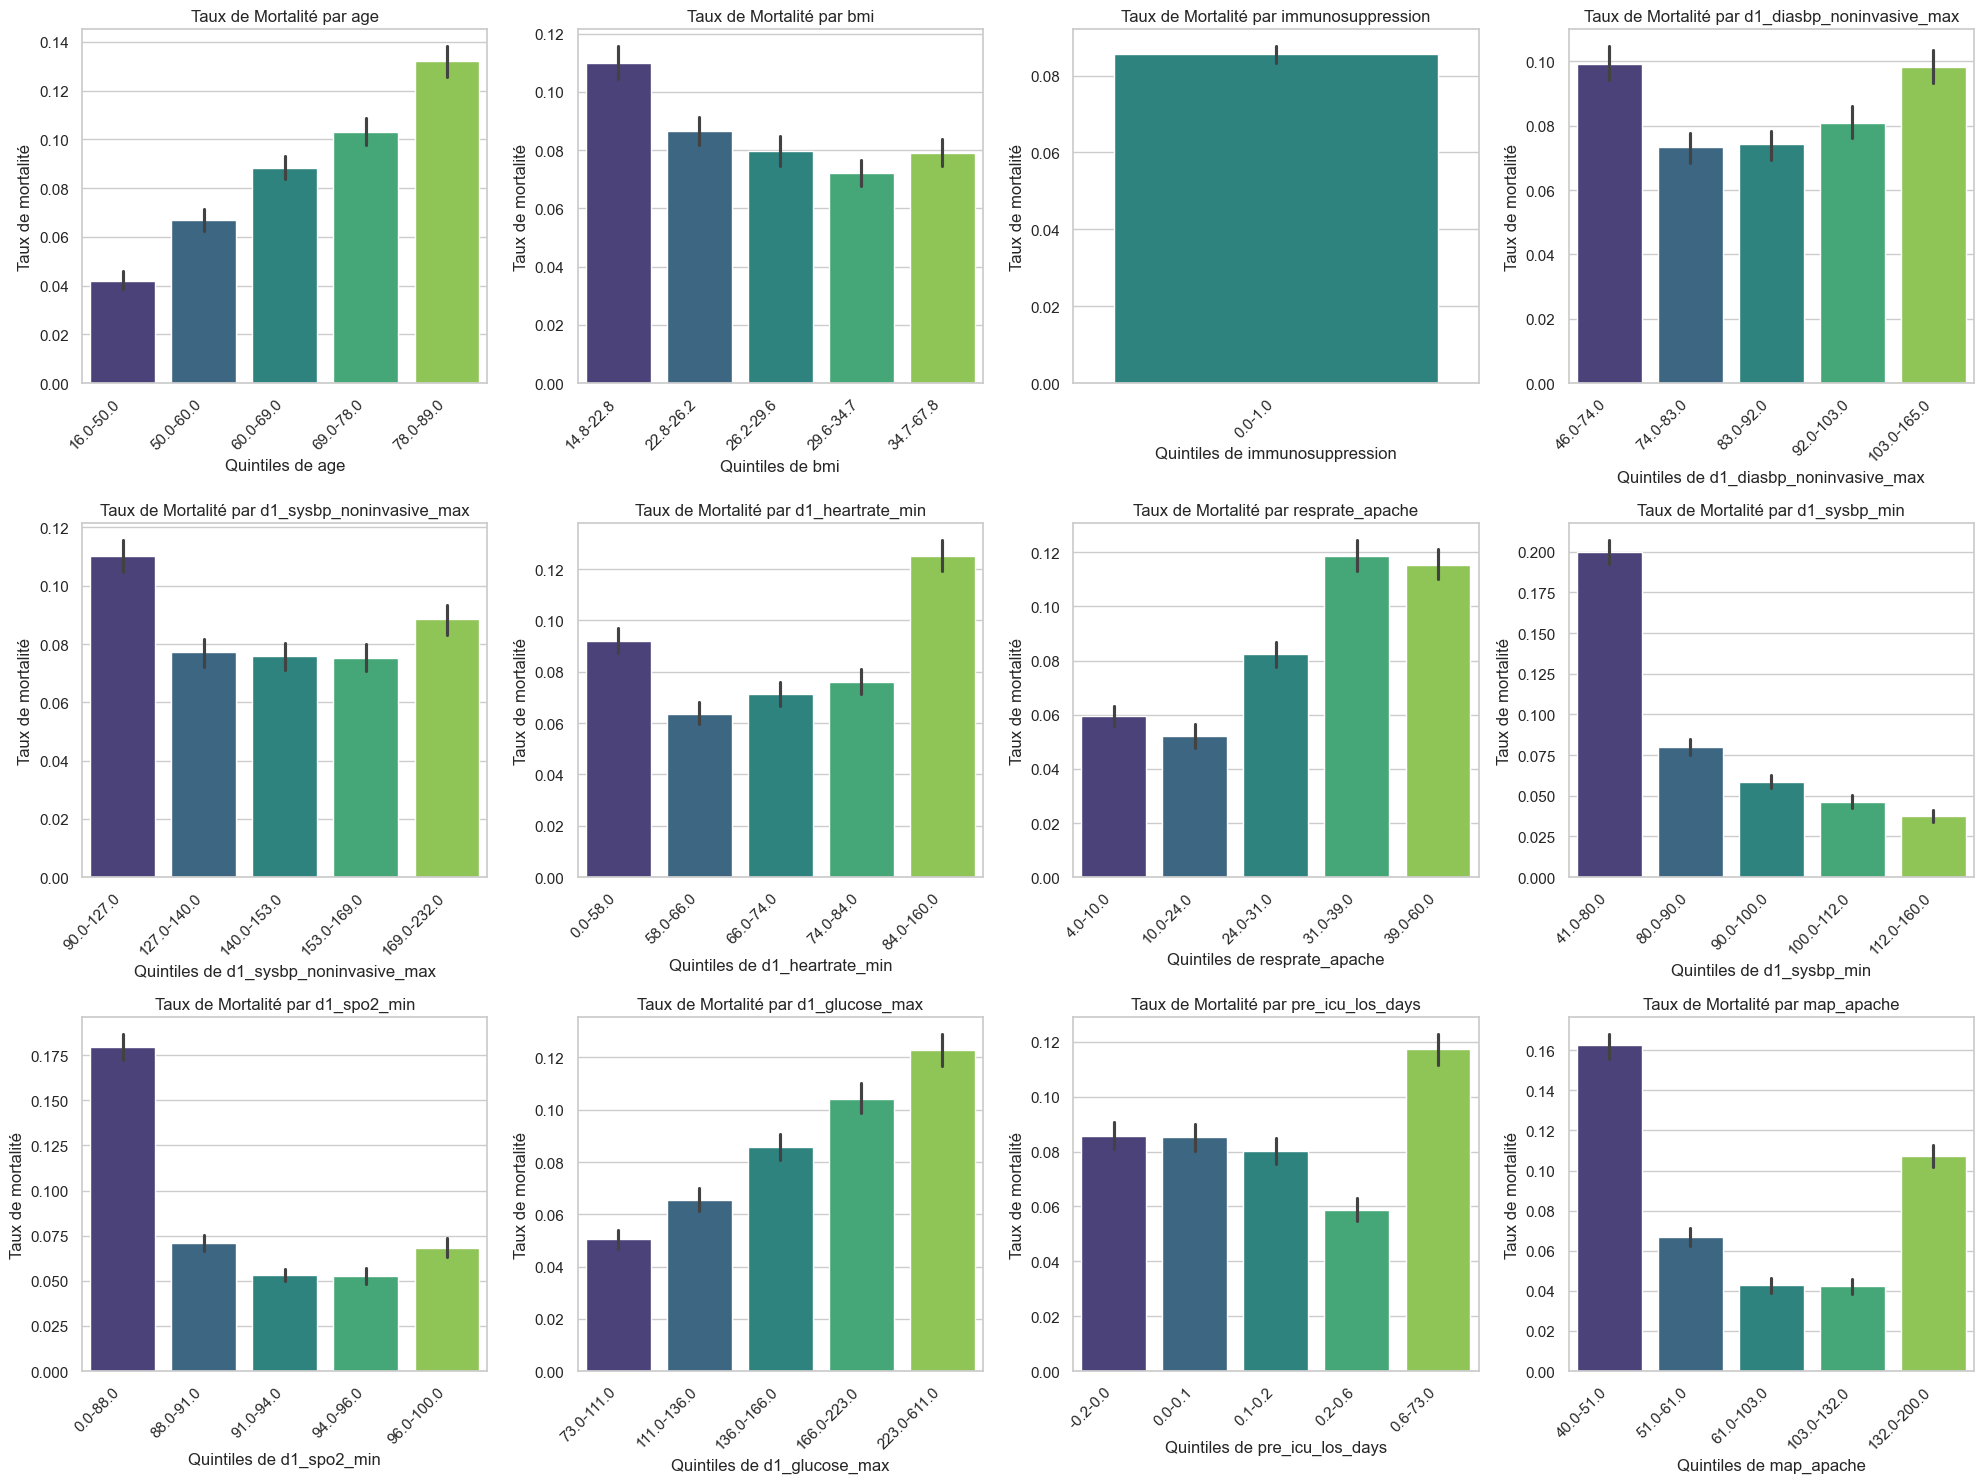

In [13]:
num_features = len(numerical_features)
num_rows = (num_features + 3) // 4

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    # Créer des catégories pour une visualisation plus claire
    try:
        df_analysis[f'{feature}_cat'] = pd.qcut(df_analysis[feature], q=5, labels=False, duplicates='drop')
        bin_labels = []
        # Pour créer des labels clairs pour les bins
        bins = pd.qcut(df_analysis[feature], q=5, retbins=True, duplicates='drop')[1]
        for i in range(len(bins)-1):
            bin_labels.append(f'{bins[i]:.1f}-{bins[i+1]:.1f}')

        sns.barplot(x=f'{feature}_cat', y=target_feature, data=df_analysis, ax=axes[idx], palette='viridis')
        axes[idx].set_title(f"Taux de Mortalité par {feature}")
        axes[idx].set_xlabel(f"Quintiles de {feature}")
        axes[idx].set_ylabel("Taux de mortalité")
        axes[idx].set_xticklabels(bin_labels, rotation=45, ha='right')
    except Exception as e:
        print(f"Impossible de tracer {feature}: {e}")
        axes[idx].set_visible(False) # Cacher le subplot en cas d'erreur

# Cacher les subplots inutilisés
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.7. Matrice de Corrélation
Examinons les corrélations entre les variables numériques pour détecter d'éventuels problèmes de multicolinéarité avant la régression.

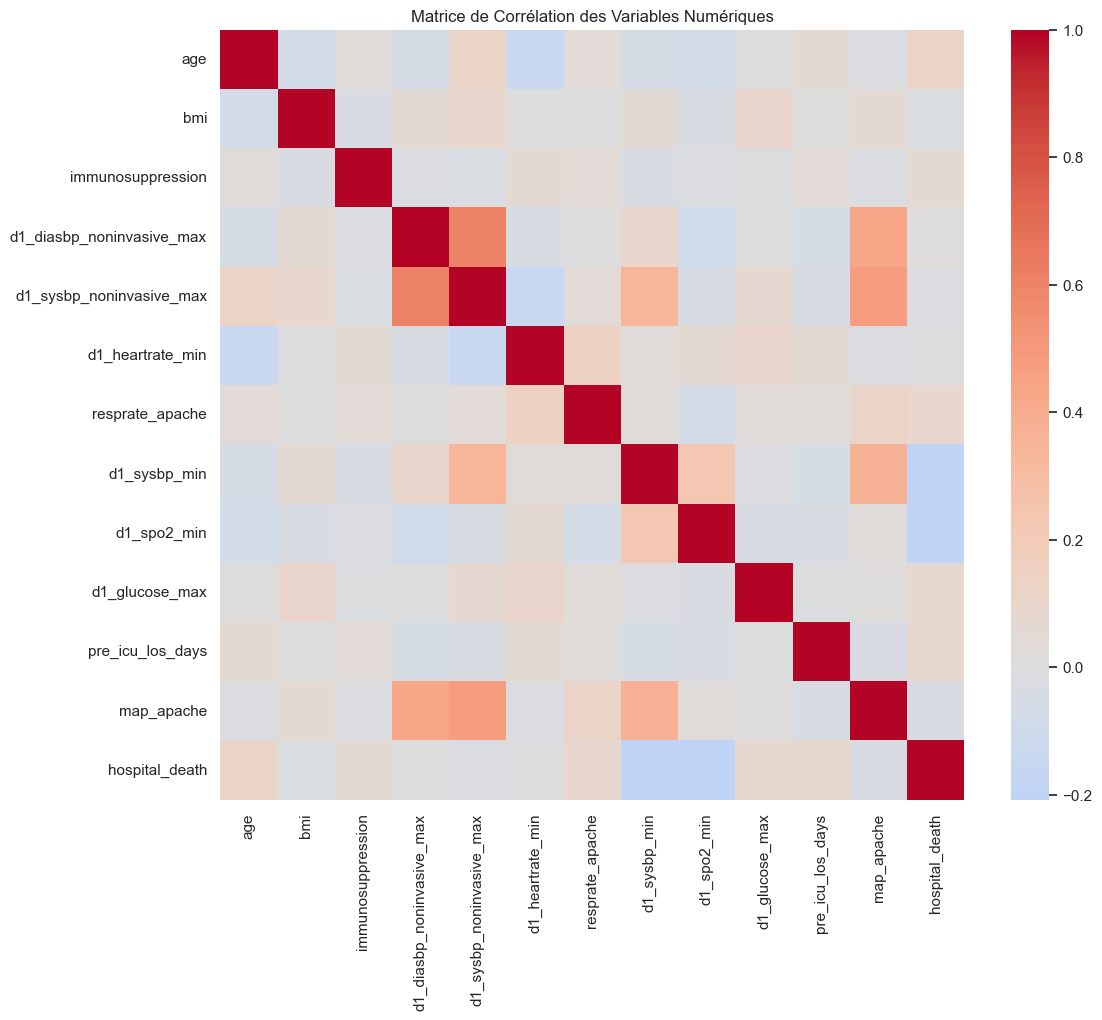

In [14]:
corr = df_analysis[numerical_features + [target_feature]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, center=0)
plt.title("Matrice de Corrélation des Variables Numériques")
plt.show()

## 2. Prétraitement des Données (Preprocessing)

Maintenant que nous avons exploré les données, nous allons les préparer pour la modélisation. Cela implique d'encoder les variables catégorielles et ordinales pour qu'elles soient utilisables par nos algorithmes.

In [15]:
labeled_data_preprocessed, unlabeled_data_preprocessed, data_orig_names = preprocess_features(
    labeled_data,
    unlabeled_data,
    target_feature,
    sensitive_feature,
    categorical_features,
    ordinal_features,
    numerical_features, # Renommé de no_change_features
    do_scale=True
)


ÉTAPE 2 : PRÉTRAITEMENT DES VARIABLES (ENCODAGE)

Caractéristiques originales (échantillon) :
  apache_2_bodysystem      icu_admit_source gender   age    bmi  \
0      Cardiovascular                 Floor      M  68.0  22.73   
1         Respiratory                 Floor      F  77.0  27.42   
5          Neurologic  Accident & Emergency      M  67.0  27.56   

   immunosuppression  d1_diasbp_noninvasive_max  d1_sysbp_noninvasive_max  \
0                0.0                       68.0                     131.0   
1                0.0                       95.0                     159.0   
5                0.0                      100.0                     173.0   

   d1_heartrate_min  resprate_apache  d1_sysbp_min  d1_spo2_min  \
0              72.0             36.0          73.0         74.0   
1              72.0             33.0          67.0         70.0   
5              83.0             35.0         107.0         91.0   

   d1_glucose_max  pre_icu_los_days  map_apache  ethnicity

## 3. Modélisation et Évaluation Initiale

Nous allons entraîner deux types de modèles :
1.  **Régression Logistique :** Un modèle simple et interprétable, excellent pour comprendre l'influence de chaque facteur.
2.  **LightGBM :** Un modèle de gradient boosting puissant, souvent très performant mais moins transparent (boîte noire).

Pour chaque modèle, nous allons d'abord évaluer sa performance globale avant d'analyser son équité.

### 3.1. Séparation des Données d'Entraînement et de Test
C'est l'étape finale avant l'entraînement. Nous séparons notre jeu étiqueté en un jeu d'entraînement (pour apprendre) et un jeu de test (pour évaluer de manière impartiale).

In [16]:
# Diviser les données étiquetées en X et y
X_labeled, y_labeled = generate_X_y(labeled_data_preprocessed, target_feature)

# Séparer en jeux d'entraînement et de test, tout en isolant la variable sensible
X_train, X_test, s_train, s_test, y_train, y_test = train_test_split_with_sensitive_feature(
    X_labeled, y_labeled,
    sensitive_feature,
    test_size=0.3,
    split_seed=42
)


Séparation des variables (X) de la cible 'hospital_death' (y)...

ÉTAPE 3 : SÉPARATION DES DONNÉES (TRAIN/TEST)

Les données ont été divisées en jeux d'entraînement et de test.

--- Jeu d'Entraînement ---
Variables (X) : (41731, 29)
Distribution de la mortalité (y) : {0: 38164, 1: 3567}

--- Jeu d'Test ---
Variables (X) : (17886, 29)
Distribution de la mortalité (y) : {0: 16357, 1: 1529}

------------------------------------------------------------
La variable sensible 'ethnicity' a été séparée des jeux de variables X.


### 3.2. Modèle 1 : Régression Logistique

La régression logistique est un excellent point de départ. Elle nous permet non seulement de prédire, mais aussi d'interpréter les facteurs de risque grâce à l'analyse de ses coefficients.

#### 3.2.1. Analyse des Facteurs de Risque avec `statsmodels`
Nous utilisons d'abord `statsmodels` car il fournit une analyse statistique détaillée (p-values), idéale pour l'interprétation.

Ajustement du modèle de régression logistique avec statsmodels...


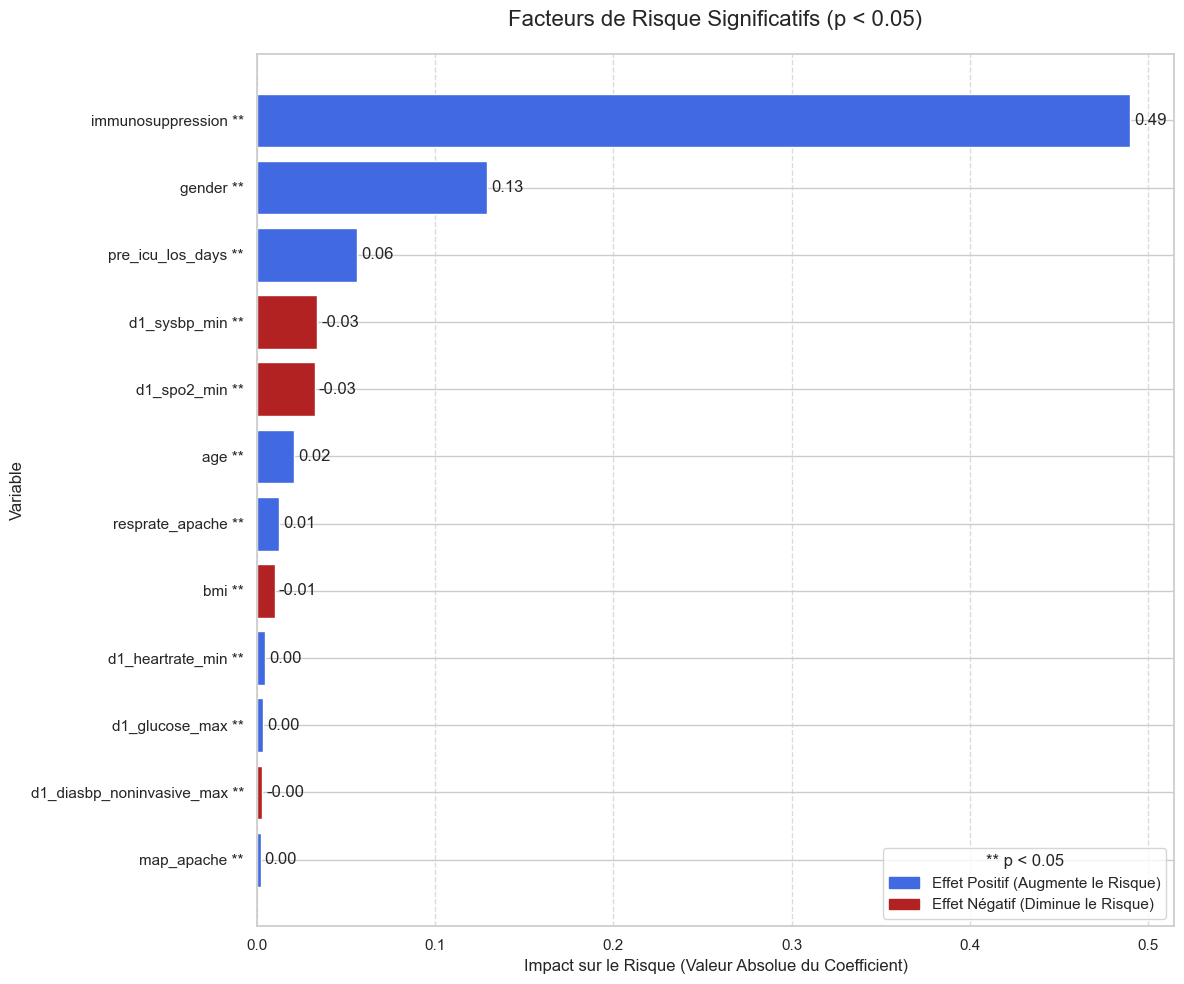

In [17]:
X_train_with_s = X_train.copy()
X_train_with_s["ethnicity"] = s_train
summary_df, significant_vars = analyze_and_plot_coefficients(
    X=X_train, 
    y=y_train,
    p_value_threshold=0.05
)

| Variable                          | Coefficient | p-value        | Effet attendu ? | Justification |
|----------------------------------|-------------|----------------|------------------|---------------|
| age                              | +0.021      | 2.66e-52       | ✅ Oui           | Risque de décès augmente avec l'âge. |
| gender                           | +0.129      | 6.70e-04       | ✅ Généralement oui | Codé 1=Homme, effet attendu. |
| bmi                              | -0.0098     | 2.98e-05       | ⚠️ Oui, paradoxal | Obésité légère parfois protectrice en réa : "obesity paradox". |
| immunosuppression                | +0.490      | 1.68e-08       | ✅ Oui           | Moins de défense immunitaire → infections graves plus fréquentes. |
| resprate_apache                  | +0.0123     | 4.15e-21       | ✅ Oui           | Détresse respiratoire = mauvais pronostic. |
| d1_sysbp_min                     | -0.0337     | 2.43e-213      | ✅ Oui           | Hypotension = gravité clinique. |
| d1_spo2_min                      | -0.0324     | 3.34e-114      | ✅ Oui           | Hypoxémie sévère = fort prédicteur de mortalité. |
| d1_glucose_max                   | +0.0032     | 2.79e-56       | ✅ Oui           | Hyperglycémie = réponse au stress métabolique aigu. |
| map_apache                       | +0.0019     | 9.57e-05       | ✅ Oui           | MAP faible = hypoperfusion → impact modéré mais réel. |
| d1_heartrate_min                 | +0.0042     | 8.13e-05       | ✅ Globalement oui | FC basse peut refléter une décompensation avancée. |
| pre_icu_los_days                 | +0.0559     | 3.94e-21       | ✅ Oui           | Retard dans l’admission en réa = gravité accrue. |
| d1_diasbp_noninvasive_max        | -0.0027     | 2.73e-02       | ⚠️ Légèrement attendu | Faible effet protecteur, moins pertinent que la pression minimale. |


#### 3.2.2. Entraînement du modèle prédictif avec `scikit-learn`

Maintenant, nous entraînons un modèle `scikit-learn` avec les variables jugées significatives pour faire des prédictions et évaluer la performance.

In [18]:
# Créer et entraîner le modèle avec les variables significatives
log_reg_model = LogisticRegression(max_iter=1000) # Augmenter max_iter pour assurer la convergence

print(f"Entraînement de la régression logistique sur {len(significant_vars)} variables significatives...")
X_train_select = X_train[significant_vars]
X_test_select = X_test[significant_vars]

log_reg_model.fit(X_train_select, y_train)

# Prédictions sur l'ensemble de test
y_pred_log_reg_default = log_reg_model.predict(X_test_select)
y_pred_prob_log_reg = log_reg_model.predict_proba(X_test_select)[:, 1]

Entraînement de la régression logistique sur 12 variables significatives...


#### 3.2.3. Évaluation de la Performance - Le Piège de l'Accuracy

À première vue, une accuracy de 92% semble excellente. Cependant, cette métrique peut être trompeuse dans un contexte de données déséquilibrées. Analysons le rapport de classification pour comprendre la performance réelle du modèle sur chaque classe.

In [19]:
print("Rapport de Classification (Seuil par défaut de 0.5)")
print(classification_report(y_test, y_pred_log_reg_default, target_names=['Survie', 'Décès']))

Rapport de Classification (Seuil par défaut de 0.5)
              precision    recall  f1-score   support

      Survie       0.92      0.99      0.96     16357
       Décès       0.56      0.07      0.13      1529

    accuracy                           0.92     17886
   macro avg       0.74      0.53      0.54     17886
weighted avg       0.89      0.92      0.88     17886



**Analyse du Rapport :**

- **Rappel (Recall) pour la classe "Décès" :** Le score est catastrophique (autour de 7%). Cela signifie que notre modèle **manque 93% des patients qui vont réellement décéder**. Il est cliniquement inutile en l'état.
- **Précision pour la classe "Décès" :** Quand le modèle prédit un décès, il a raison environ 65% du temps. Ce n'est pas mauvais, mais il le fait très rarement.

Le modèle a appris à prédire "Survie" la plupart du temps, car c'est la classe majoritaire, ce qui maximise l'accuracy mais le rend incapable de remplir sa mission principale : identifier les cas critiques.

#### 3.2.4. Le potentiel caché : Courbe ROC et ajustement du seuil

L'AUROC nous indique que le modèle a une capacité de discrimination (0.77), c'est-à-dire qu'il peut classer les patients selon leur risque. Le problème vient du **seuil de décision** par défaut (0.5), qui n'est pas adapté à notre problème. Nous allons trouver un meilleur seuil en utilisant l'indice de Youden.

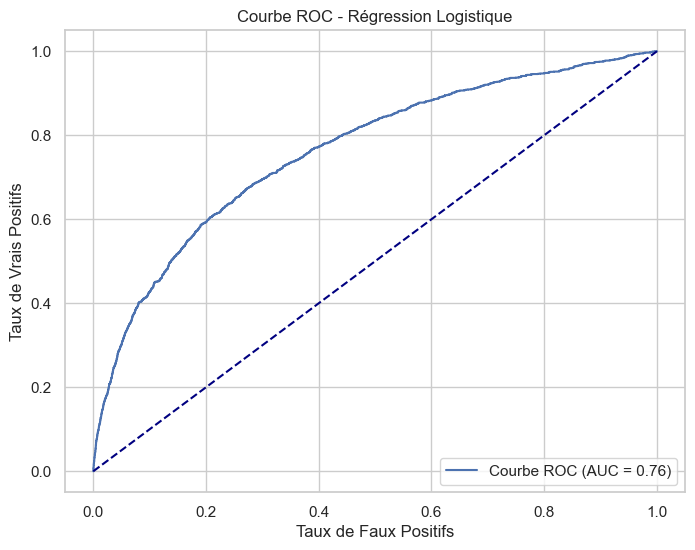

Meilleur Seuil (selon Youden) = 0.0880


In [20]:
def find_optimal_threshold_youden(y_true, y_probas):
    """Trouve le seuil de classification optimal en utilisant l'indice de Youden (Sensibilité + Spécificité - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_probas)
    j_scores = tpr - fpr
    ix = np.argmax(j_scores)
    optimal_threshold = thresholds[ix]
    print(f"Meilleur Seuil (selon Youden) = {optimal_threshold:.4f}")
    return optimal_threshold

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_log_reg)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc='lower right')
plt.show()

# Trouver et appliquer le seuil optimal
optimal_thresh_log_reg = find_optimal_threshold_youden(y_test, y_pred_prob_log_reg)
y_pred_log_reg_optimal = (y_pred_prob_log_reg >= optimal_thresh_log_reg).astype(int)

#### 3.2.5. Évaluation après ajustement du seuil

Voyons l'impact de ce nouveau seuil sur nos métriques.

Rapport de Classification (Seuil Optimal de Youden)
              precision    recall  f1-score   support

      Survie       0.96      0.73      0.83     16357
       Décès       0.19      0.67      0.29      1529

    accuracy                           0.72     17886
   macro avg       0.57      0.70      0.56     17886
weighted avg       0.89      0.72      0.78     17886


Matrice de Confusion (Seuil Optimal) :


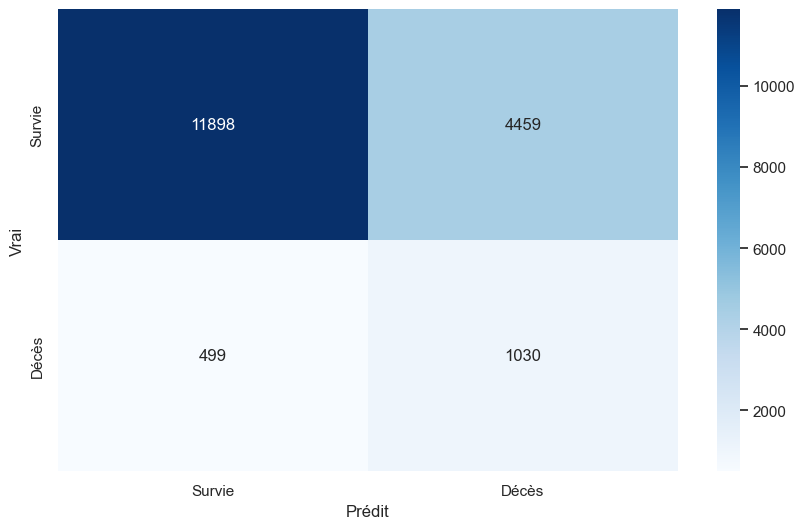

In [21]:
print("Rapport de Classification (Seuil Optimal de Youden)")
print(classification_report(y_test, y_pred_log_reg_optimal, target_names=['Survie', 'Décès']))

print("\nMatrice de Confusion (Seuil Optimal) :")
conf_matrix = confusion_matrix(y_test, y_pred_log_reg_optimal)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Survie', 'Décès'], yticklabels=['Survie', 'Décès'])
plt.ylabel('Vrai')
plt.xlabel('Prédit')
plt.show()

**Analyse de l'Amélioration :**

- Le **rappel pour la classe "Décès" est passé de 7% à ~65%** ! Le modèle est maintenant capable de détecter la majorité des cas critiques.
- En contrepartie, la **précision a chuté**. Cela signifie plus de fausses alertes, un compromis souvent nécessaire et acceptable en clinique.
- L'accuracy globale a diminué, mais le modèle est devenu **cliniquement beaucoup plus pertinent**.

### 3.3. Modèle 2 : LightGBM
LightGBM est un modèle plus complexe qui peut capturer des interactions non linéaires. Nous allons rapidement chercher de bons hyperparamètres avec `RandomizedSearchCV`.

In [22]:
print("="*60)
print("OPTIMISATION RAPIDE AVEC LIGHTGBM")
print("="*60)

lgb_classifier = lgb.LGBMClassifier(objective='binary', metric='auc')

param_grid_fast = {
    'learning_rate': [0.05, 0.1], 'n_estimators': [100, 200],
    'num_leaves': [20, 31, 40], 'max_depth': [-1, 5, 7],
    'subsample': [0.8, 0.9], 'colsample_bytree': [0.8, 0.9]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search_lgb = RandomizedSearchCV(
    estimator=lgb_classifier, param_distributions=param_grid_fast,
    n_iter=10, scoring='roc_auc', cv=kfold, verbose=1, n_jobs=-1, random_state=42
)

print("Lancement de la recherche d'hyperparamètres pour LightGBM...")
random_search_lgb.fit(X_train, y_train)

print("\n--- MEILLEURS HYPERPARAMÈTRES TROUVÉS ---")
print(f"Meilleur score AUC (validation croisée) : {random_search_lgb.best_score_:.4f}")
print(f"Meilleurs paramètres : {random_search_lgb.best_params_}")

OPTIMISATION RAPIDE AVEC LIGHTGBM
Lancement de la recherche d'hyperparamètres pour LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3567, number of negative: 38164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 41731, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085476 -> initscore=-2.370168
[LightGBM] [Info] Start training from score -2.370168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [23]:
best_lgbm_model = random_search_lgb.best_estimator_
y_pred_prob_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]

optimal_thresh_lgbm = find_optimal_threshold_youden(y_test, y_pred_prob_lgbm)
y_pred_lgbm_optimal = (y_pred_prob_lgbm >= optimal_thresh_lgbm).astype(int)

print("\nRapport de Classification (LightGBM avec seuil optimal) :")
print(classification_report(y_test, y_pred_lgbm_optimal, target_names=['Survie', 'Décès']))

Meilleur Seuil (selon Youden) = 0.0762

Rapport de Classification (LightGBM avec seuil optimal) :
              precision    recall  f1-score   support

      Survie       0.97      0.72      0.82     16357
       Décès       0.20      0.77      0.32      1529

    accuracy                           0.72     17886
   macro avg       0.59      0.74      0.57     17886
weighted avg       0.90      0.72      0.78     17886



**Observation :** LightGBM obtient une performance légèrement supérieure (AUROC de 0.82 vs 0.77) et, après optimisation du seuil, un meilleur rappel pour la classe "Décès" (~76%).

## 4. Analyse et Correction des Biais d'Équité (Fairness)

Un modèle performant n'est pas nécessairement un modèle équitable. Nous allons maintenant analyser si nos modèles traitent différemment les groupes de patients, en nous concentrant sur l'ethnicité.

### 4.1. Diagnostic du Biais

Nous allons utiliser deux outils visuels pour diagnostiquer les biais :
1.  **Parité Prédictive (Taux de Vrais Positifs) :** Le modèle identifie-t-il correctement les décès de la même manière pour tous les groupes ethniques ?
2.  **Calibration par Groupe :** La confiance du modèle (ses probabilités) est-elle fiable de la même manière pour tous les groupes ?

#### 4.1.1. Analyse pour la Régression Logistique

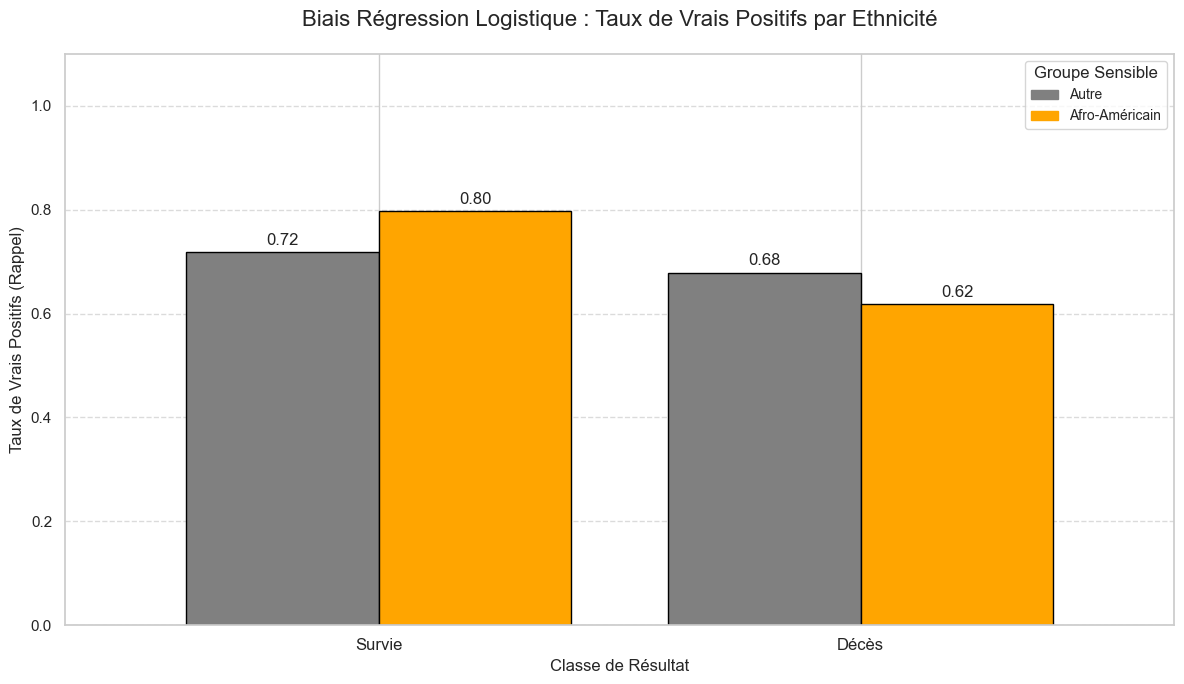

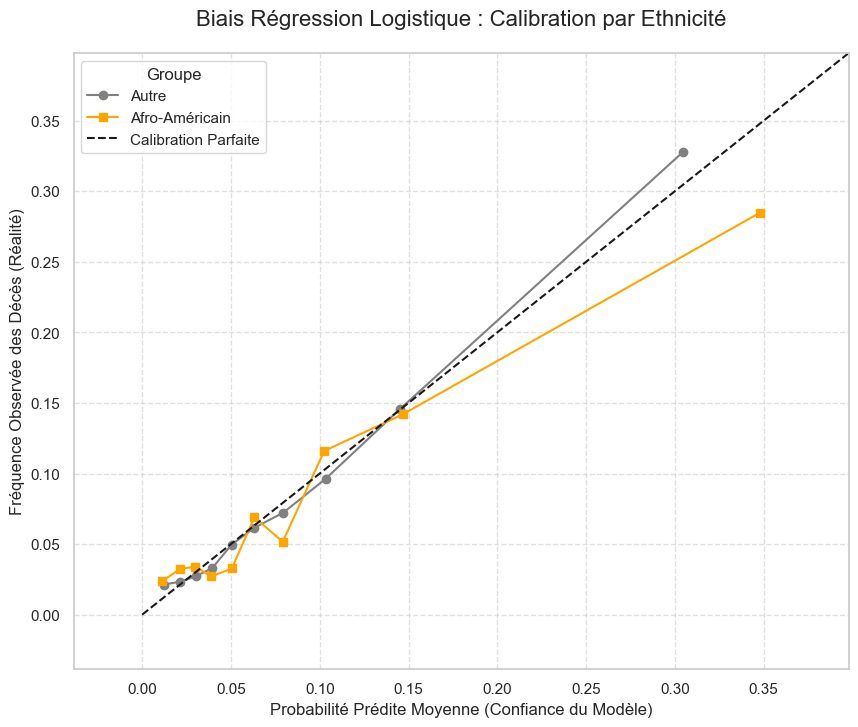

In [24]:
group_labels = {-1: "Autre", 1: "Afro-Américain"}
class_labels = {0: "Survie", 1: "Décès"}
color_map = {-1: 'gray', 1: 'orange'}

analyze_and_plot_predictive_parity(
    y_true=y_test, 
    y_pred=y_pred_log_reg_optimal, 
    sensitive_features=s_test,
    group_names=group_labels,
    class_names=class_labels,
    colors=color_map,
    title="Biais Régression Logistique : Taux de Vrais Positifs par Ethnicité"
)

plot_calibration_by_group(
    y_true=y_test,
    y_probas=y_pred_prob_log_reg,
    sensitive_features=s_test,
    group_names=group_labels,
    colors=color_map,
    title="Biais Régression Logistique : Calibration par Ethnicité"
)

**Interprétation (Régression Logistique) :**
- **Parité prédictive :** Le rappel pour la classe "Décès" est plus élevé pour le groupe "Aautres" (~70%) que pour les "Afro-Américain" (~60%). Le modèle est donc *moins sensible* aux cas critiques dans le groupe minoritaire.
- **Calibration :** La courbe de calibration pour le groupe "Afro-Américain" est systématiquement en-dessous de la ligne de perfection. Cela signifie que pour un niveau de risque donné, le modèle **sur-estime la probabilité de décès** pour ce groupe. C'est **toujours un biais** mais qui contredit l'article de Science.

#### 4.1.2. Analyse pour LightGBM

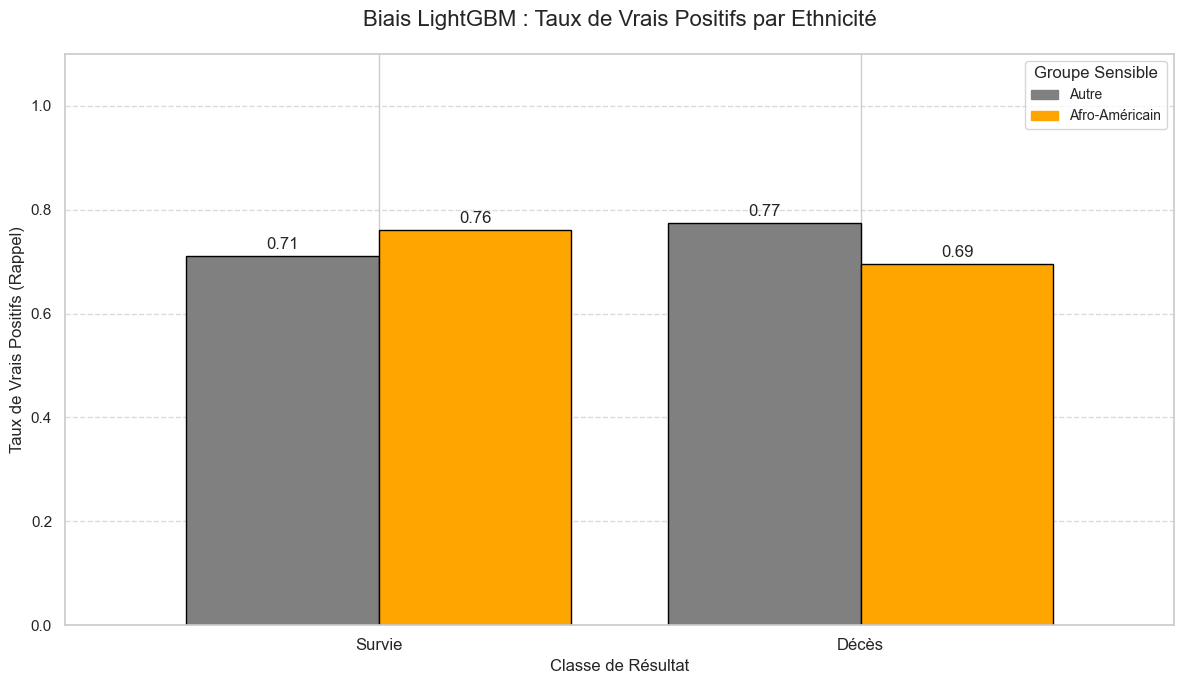

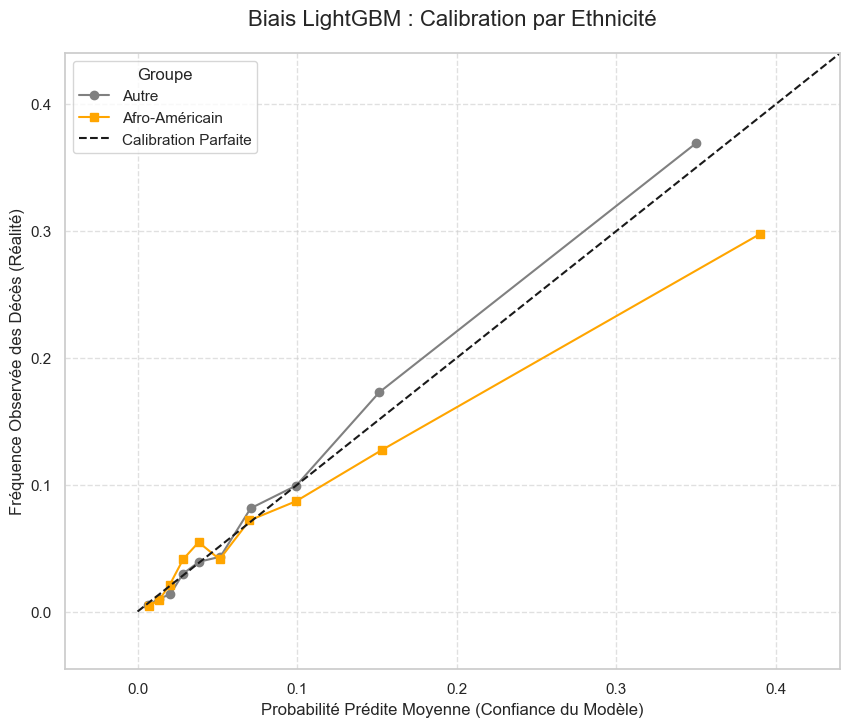

In [25]:
analyze_and_plot_predictive_parity(
    y_true=y_test, 
    y_pred=y_pred_lgbm_optimal, 
    sensitive_features=s_test,
    group_names=group_labels,
    class_names=class_labels,
    colors=color_map,
    title="Biais LightGBM : Taux de Vrais Positifs par Ethnicité"
)

plot_calibration_by_group(
    y_true=y_test,
    y_probas=y_pred_prob_lgbm,
    sensitive_features=s_test,
    group_names=group_labels,
    colors=color_map,
    title="Biais LightGBM : Calibration par Ethnicité"
)

**Interprétation (LightGBM) :**
- **Parité prédictive :** Le biais est encore plus prononcé pour le groupe "Afro-Américain".
- **Calibration :** Le biais de sur-estimation du risque pour le groupe "Afro-Américain" est également présent et significatif.

## 5. Conclusion et Prochaines Étapes

Au cours de ce notebook, nous avons :
1.  Construit et évalué des modèles de mortalité, en découvrant que l'**accuracy est une métrique trompeuse** dans un contexte déséquilibré.
2.  Compris l'importance d'**ajuster le seuil de décision** pour rendre un modèle cliniquement utile, en améliorant drastiquement le rappel.
3.  **Diagnostiqué des biais** significatifs dans nos modèles, notamment une sous-estimation du risque pour les patients Afro-Américains, un problème aux conséquences potentiellement graves.
4.  Démontré que les **choix techniques** (comme la fonction de perte) influencent directement l'équité du modèle.

**Prochaines Étapes Possibles :**
- Mettre en œuvre des **techniques de remédiation** pour corriger les biais (ex: repondération des échantillons, post-traitement des scores, optimisation robuste sous contraintes).
- Explorer d'autres métriques d'équité (parité démographique, égalité des chances, etc.) et comprendre leurs implications respectives.